In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw 
from sklearn.preprocessing import * 
import time 
import ast 
import os 
import keras 
import tensorflow as tf 
from keras import models, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers, initializers, regularizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout 
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten 
from keras.models import Sequential 
from keras.metrics import top_k_categorical_accuracy 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
#from keras.applications import ResNet50, vgg19,mobilenet_v2,InceptionV3 , InceptionResNetV2,DenseNet169 
from tqdm import tqdm 
import cv2
from sklearn.model_selection import train_test_split 
from keras.models import load_model

In [2]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2.5.0
2.5.0


In [3]:
# outputMode = 0 -> 모델 결과값 그대로 
# outputMode = 1 -> 결과값에 argmax 후  
def Fruit_Classifier(inputdata, outputMode = 0):
    # 0 = Front = [1,0,0], 1 = Back = [0,1,0], 2 = Side = = [0,0,1]
    direction_output = direction_model.predict(inputdata)
    Y_direction_predict = []
    for a in direction_output:
        Y_direction_predict.append(np.argmax(a))
    side_list = []
    side_number = []
    front_list = []
    front_number = []
    back_list = []
    back_number = []
    
    for i, b in enumerate(Y_direction_predict):
        if b == 0 :
            front_list.append(inputdata[i].tolist())
            front_number.append(i)
        elif b == 1:
            back_list.append(inputdata[i].tolist())
            back_number.append(i)
        else:
            side_list.append(inputdata[i].tolist())
            side_number.append(i)
    side_list = np.array(side_list)  
    front_list = np.array(front_list) 
    back_list = np.array(back_list) 
    front_output = []
    back_output = []
    side_output = []
    
    # Bad = 0 = [1,0], Normal = 1 = [0,1]
    if len(front_list) > 0:
        _front_output = Front_model.predict(front_list)
        del front_list
        if outputMode == 0:
            front_output.append(_front_output.tolist())
        else:
            for i in _front_output:
                front_output.append(np.argmax(i))
    if len(back_list) > 0:
        _back_output = Back_model.predict(back_list)
        del back_list
        if outputMode == 0: 
            back_output.append(_back_output.tolist())
        else:
            for i in _back_output:
                back_output.append(np.argmax(i))
    if len(side_list) > 0:
        _side_output = Side_model.predict(side_list) 
        del side_list
        if outputMode == 0:
            side_output.append(_side_output.tolist())
        else:
            for i in _side_output:
                side_output.append(np.argmax(i))
    return Y_direction_predict, front_number, front_output, back_number, back_output, side_number, side_output

# 확률값 반환 함수
def function1(list1, list2):
    count = 0
    for i, j in zip(list1, list2):
        if i == j:
            count += 1
    return count / len(list1)


#  확률값 반환 + 리스트 비교 시 값이 다른 곳의 위치 반환
def function2(list1, list2):
    #if list1 != list2:
    #  return 
    count = 0
    othervalue_list = []
    for i, list_set in enumerate(zip(list1, list2)):
        if list_set[0] == list_set[1]:
            count += 1
        else:
            othervalue_list.append(i)
    output_per = count / len(list1)
    return output_per, othervalue_list

# 방향 구별 모델에서 다른 결과값의 리스트 제거
def del_list(othervalue_list, del_list):
    for i in othervalue_list:
        del del_list[i]

#결과값 정렬 알고리즘
def output_sorting(front_number, front_output, back_number, back_output, side_number, side_output):
    list_output = []
    list_num = []
    for i in front_output:
        list_output.append(i)
    for i in back_output:
        list_output.append(i)
    for i in side_output:
        list_output.append(i)
        
    for i in front_number:
        list_num.append(i)
    for i in back_number:
        list_num.append(i)
    for i in side_number:
        list_num.append(i)
        
    length = len(list_num)
    for i in range(length):
        length2 = length - i
        for j in range(length2):
            if list_num[i] > list_num[j + i]:
                num = list_num[i]
                output = list_output[i]
                list_num[i] = list_num[j + i]
                list_output[i] = list_output [ j + i]
                list_num[j + i] = num
                list_output [ j + i] = output
    return list_num, list_output

In [4]:
path = 'C:/Users/sdf80/Desktop/fruit_dataset_augmentation/v3/ValidationSet/'

filename = os.listdir(path)
datalist = pd.DataFrame(data=[], columns=['label','img'])

label = []
img = []

for file in tqdm(filename):
    split_label = file.split('.')
    label.append(split_label[0]+ split_label[1])
    img.append(file)
    
datalist['label'] = label
datalist['img'] = img 

def preprocessing(path) :
    X = []
    y_FullName = []
    y_StateNum = []
    y_DirectionNum = []
    class_label = []
    class_num = 6
    
    for num in tqdm(range(len(datalist['img']))) :
        img = cv2.imread(path+datalist['img'][num])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        
        if datalist['label'][num] == 'SideBad': 
            X.append(img) 
            y_FullName.append('SideBad') 
            y_StateNum.append(0)
            y_DirectionNum.append(2)
        elif datalist['label'][num] == 'SideNormal':
            X.append(img) 
            y_FullName.append('SideNormal')
            y_StateNum.append(1)
            y_DirectionNum.append(2)
        elif datalist['label'][num] == 'FrontBad': 
            X.append(img) 
            y_FullName.append('FrontBad')
            y_StateNum.append(0)
            y_DirectionNum.append(0)
        elif datalist['label'][num] == 'FrontNormal': 
            X.append(img) 
            y_FullName.append('FrontNormal')
            y_StateNum.append(1)
            y_DirectionNum.append(0)
        elif datalist['label'][num] == 'BackBad': 
            X.append(img) 
            y_FullName.append('BackBad')
            y_StateNum.append(0)
            y_DirectionNum.append(1)
        elif datalist['label'][num] == 'BackNormal': 
            X.append(img) 
            y_FullName.append('BackNormal')
            y_StateNum.append(1)
            y_DirectionNum.append(1)
        else:
            print('알림')
            
    X = np.array(X) 
    y_FullName = np.array(y_FullName) 
    y_StateNum = np.array(y_StateNum) 
    y_DirectionNum = np.array(y_DirectionNum) 
    
    #y_FullName = np.array([[i] for i in y_FullName]) 
    #y_StateNum = np.array([[i] for i in y_StateNum]) 
    #y_DirectionNum = np.array([[i] for i in y_DirectionNum]) 
    
    #enc = OneHotEncoder(categories='auto') 
    #enc.fit(y_StateNum) 
    #tmpy = enc.transform(y_StateNum).toarray() 

    #del Y #RAM메모리 절약을 위해 사용하지 않는 변수 삭제
    return X, y_FullName, y_StateNum ,y_DirectionNum, class_label , class_num


X, y_FullName, y_StateNum, y_DirectionNum, class_label, class_num = preprocessing(path)
X = X/ 255
#파일이름이 담긴 배열 

print(X.shape, y_FullName.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 370.85it/s]

(185, 160, 160, 3) (185,)


In [5]:
model_path = 'C:/Users/sdf80/Desktop/Colab_Model/Model_v3/'

In [11]:
direction_name=os.path.join(model_path, 'Colab_Direction_VGG19.h5')
side_name=os.path.join(model_path, 'Colab_Side_VGG19.h5')
front_name=os.path.join(model_path, 'Colab_Front_VGG19.h5')
back_name=os.path.join(model_path, 'Colab_Back_VGG19.h5')

In [17]:
direction_name=os.path.join(model_path, 'Colab_Direction_ResNet50.h5')
side_name=os.path.join(model_path, 'Colab_Side_ResNet50.h5')
front_name=os.path.join(model_path, 'Colab_Front_ResNet50.h5')
back_name=os.path.join(model_path, 'Colab_Back_ResNet50.h5')

In [6]:
direction_name=os.path.join(model_path, 'Colab_Direction_Inception.h5')
side_name=os.path.join(model_path, 'Colab_Side_Inception.h5')
front_name=os.path.join(model_path, 'Colab_Front_Inception.h5')
back_name=os.path.join(model_path, 'Colab_Back_InceptionV3.h5')

In [35]:
direction_name=os.path.join(model_path, 'Colab_Direction_Modified_MobileNet.h5')
side_name=os.path.join(model_path, 'Colab_Side_Modified_MobileNet.h5')
front_name=os.path.join(model_path, 'Colab_Front_Modified_MobileNet.h5')
back_name=os.path.join(model_path, 'Colab_Back_Modified_MobileNet.h5')

In [7]:
direction_model = models.load_model(direction_name)
Side_model = models.load_model(side_name)
Front_model = models.load_model(front_name)
Back_model = models.load_model(back_name)

In [8]:
y_direction_predict, front_number, front_output, back_number, back_output, side_number, side_output = Fruit_Classifier(X, 1)

In [28]:
len(y_direction_predict)

185

In [21]:
print('front_number: ', front_number)
print('front_output: ', front_output)
print('----------------------------------------------------------------')
print('back_number: ', back_number)
print('back_output: ', back_output)
print('----------------------------------------------------------------')
print('side_number: ', side_number)
print('side_output: ', side_output)
print('----------------------------------------------------------------')

front_number:  [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
front_output:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1]
----------------------------------------------------------------
back_number:  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 114]
back_output:  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
----------------------------------------------------------------
side_number:  [7, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 

In [22]:
# 하나만 넣으면 오류뜸.
#state_output = Front_model.predict(X[1])

In [9]:
list_num, list_output = output_sorting(front_number, front_output, back_number, back_output, side_number, side_output)

In [10]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# InceptionV3

Confusion matrix, without normalization
[[134   9]
 [ 19  23]]


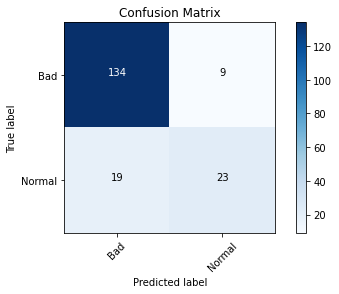

In [15]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

Confusion matrix, without normalization
[[133  10]
 [ 14  28]]


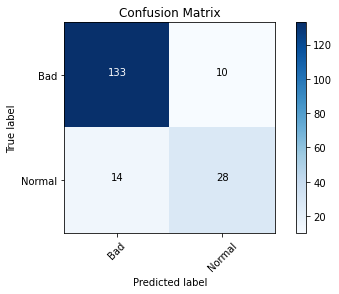

In [11]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

# ResNet50

Confusion matrix, without normalization
[[137   6]
 [ 18  24]]


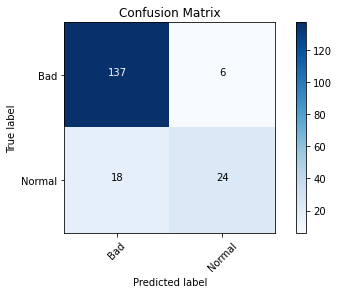

In [25]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

# VGG19

Confusion matrix, without normalization
[[137   6]
 [ 30  12]]


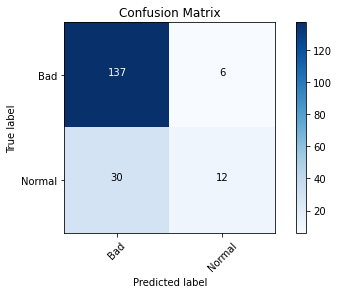

In [16]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

# Modified MobileNet

Confusion matrix, without normalization
[[137   6]
 [ 20  22]]


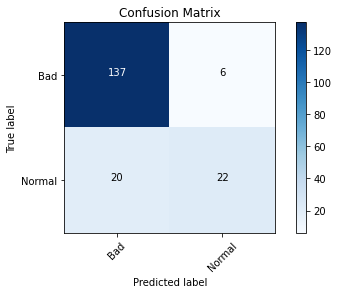

In [39]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')